# 1 Predicting Gender of Brazilian Names Using Deep Learning in Data Lattes

## 1.1 Necessary libraries

In [68]:
import numpy as np
import pandas as pd                       
from joblib import dump, load
from tensorflow import keras
from unidecode import unidecode
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Bidirectional, Activation

## 1.2 Read the dataset

In [2]:
DataLattes = pd.read_csv(r"..\web-scraping-from-lattes\dataLattes.csv")

In [3]:
DataLattes.head()

,Unnamed: 0,primeiro_nome,nome_completo,formacao,titulo,ano
0,0,Jussiê,Jussiê Soares da Rocha,doutorado,Numerical Techniques For Future Applications ...,2018
1,1,Álvaro,Álvaro Itaúna Schalcher Pereira,doutorado,Estudo de caso dos colaboradores da Unidade d...,2018
2,2,Álvaro,Álvaro Itaúna Schalcher Pereira,doutorado,Determinação da porosidade drenável em amostr...,2018
3,3,Álvaro,Álvaro Itaúna Schalcher Pereira,doutorado,Evaluation of conservational practices of the...,2018
4,4,Álvaro,Álvaro Itaúna Schalcher Pereira,doutorado,Solos de Textura Arenosa e Argilosa,2018


In [4]:
DataLattes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455794 entries, 0 to 455793
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     455794 non-null  int64 
 1   primeiro_nome  455794 non-null  object
 2   nome_completo  455794 non-null  object
 3   formacao       455794 non-null  object
 4   titulo         455794 non-null  object
 5   ano            455794 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 20.9+ MB


In [5]:
print("Doutorado : " + str(sum(DataLattes["formacao"]=="doutorado")))
print("Mestado : " + str(sum(DataLattes["formacao"]=="mestrado")))

Doutorado : 391000
Mestado : 64794


### 1.2.1 Preparing the data

In [22]:
namesDout = DataLattes[DataLattes["formacao"]=="doutorado"]['primeiro_nome'].apply(lambda x: unidecode(str(x)).lower().replace("-", " "))
namesMest = DataLattes[DataLattes["formacao"]=="mestrado"]['primeiro_nome'].apply(lambda x: unidecode(str(x)).lower().replace("-", " "))

In [23]:
tmp = list(namesDout)
names = DataLattes[DataLattes["formacao"]=="doutorado"]['nome_completo']
for x, name in zip(range(len(tmp)),names):
    if "ev'" == tmp[x]:
        aux = name.split()
        aux = aux[0].replace("'","") + " " + aux[1]
        tmp[x] = unidecode(aux).lower()
    if "'" in tmp[x]:
        tmp[x] = tmp[x].replace("'","")
namesDout = tmp

In [24]:
tmp = list(namesMest)
for x in range(len(tmp)):
    if "'" in tmp[x]:
        tmp[x] = tmp[x].replace("'"," ")

namesMest = tmp

## 1.3 Encoding Words

In [26]:
#word encoding
maxlen = 20                                               # max lenght of a name

'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in namesDout]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)

char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary
''' The dictionary maps each letter of vocabulary to a number '''

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

'''This is called one-hot-encoder and is based on the following papers: 
https://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names
https://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...
 '''

'This is called one-hot-encoder and is based on the following papers: \nhttps://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names\nhttps://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...\n '

In [28]:
x_mest = prepare_encod_names(namesMest)

In [ ]:
x_dout = prepare_encod_names(namesDout)

## 1.4 BiLSTM Model

In [29]:
bilstm = keras.Sequential()
bilstm.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2), 
                            backward_layer=LSTM(128, return_sequences=False, go_backwards=True, dropout=0.2, recurrent_dropout=0.2),
                            input_shape=(maxlen,len_vocab)))
bilstm.add(Dense(1, activity_regularizer=l2(0.002)))
bilstm.add(Activation('sigmoid'))

In [30]:
bilstm.load_weights(filepath=r"../machine-learning-models/deep-learning-models/BiLSTM/Model/BiLSTM.hdf5")

## 1.5 Predict Gender

### 1.5.1 Data of master's degree 

In [31]:
resu=(bilstm.predict(x_mest) > 0.5).astype("int32")

In [37]:
dump(resu, r"./results/Mestrado.hdf5")

['./results/Mestrado.hdf5']

#### 1.5.1.1 Analysis of results - Master's

In [98]:
print("M : " + str(sum(resu==0)))
print("F : " + str(sum(resu==1)))

M : [60850]
F : [3944]


In [100]:
dftmp = pd.DataFrame(columns=["M","F"])
dftmp["M"] = [int(sum(resu==0))]
dftmp["F"] = [int(sum(resu==1))]

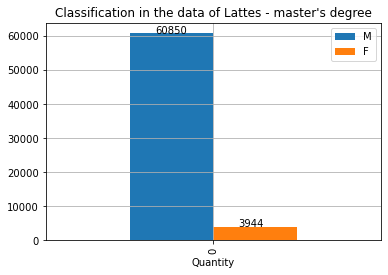

In [101]:
ax = dftmp.plot(kind="bar")
plt.title("Classification in the data of Lattes - master's degree")
plt.grid('True')
plt.xlabel('Quantity')
x_offset = -0.05
y_offset = 2.5
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

### 1.5.1 Data of doctorate degree

#### 1.5.1.1 Split data

Due to the amount of data, it is necessary to do the division for the classification to take place. Such limitation is due to the amount of memory used in the process.

In [41]:
namesDout, namesDoutpt1 = train_test_split(namesDout, test_size=0.25)
namesDout, namesDoutpt2 = train_test_split(namesDout, test_size=0.25)
namesDoutpt3, namesDoutpt4 = train_test_split(namesDout, test_size=0.25)

#### 1.5.1.2 Part 1

In [42]:
x_dout = prepare_encod_names(namesDoutpt1)

In [ ]:
resu=(bilstm.predict(x_dout) > 0.5).astype("int32")

In [138]:
print("M : " + str(sum(resu==0)))
print("F : " + str(sum(resu==1)))

M : [52617]
F : [2368]


In [139]:
dftmp = pd.DataFrame(columns=["M","F"])
dftmp["M"] = [int(sum(resu==0))]
dftmp["F"] = [int(sum(resu==1))]

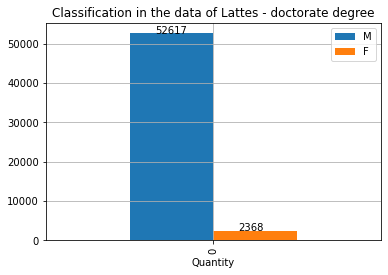

In [140]:
ax = dftmp.plot(kind="bar")
plt.title("Classification in the data of Lattes - doctorate degree")
plt.grid('True')
plt.xlabel('Quantity')
x_offset = -0.05
y_offset = 2.5
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

#### 1.5.1.3 Part 2

In [49]:
x_dout = prepare_encod_names(namesDoutpt2)

In [50]:
resu=(bilstm.predict(x_dout) > 0.5).astype("int32")

In [51]:
dump(resu, r"./results/DoutoradoPt2.hdf5")

['./results/DoutoradoPt2.hdf5']

In [134]:
print("M : " + str(sum(resu==0)))
print("F : " + str(sum(resu==1)))

M : [52617]
F : [2368]


In [135]:
dftmp = pd.DataFrame(columns=["M","F"])
dftmp["M"] = [int(sum(resu==0))]
dftmp["F"] = [int(sum(resu==1))]

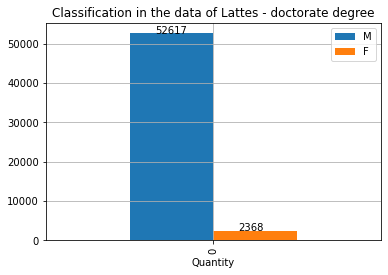

In [136]:
ax = dftmp.plot(kind="bar")
plt.title("Classification in the data of Lattes - doctorate degree")
plt.grid('True')
plt.xlabel('Quantity')
x_offset = -0.05
y_offset = 2.5
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

#### 1.5.1.4 Part 3

In [55]:
x_dout = prepare_encod_names(namesDoutpt3)

In [56]:
resu=(bilstm.predict(x_dout) > 0.5).astype("int32")

In [57]:
dump(resu, r"./results/DoutoradoPt3.hdf5")

['./results/DoutoradoPt3.hdf5']

In [130]:
print("M : " + str(sum(resu==0)))
print("F : " + str(sum(resu==1)))

M : [88917]
F : [3868]


In [131]:
dftmp = pd.DataFrame(columns=["M","F"])
dftmp["M"] = [int(sum(resu==0))]
dftmp["F"] = [int(sum(resu==1))]

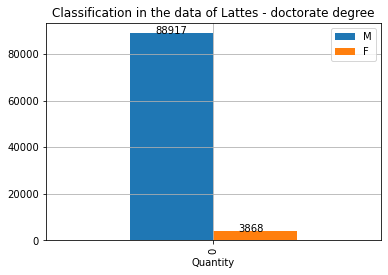

In [132]:
ax = dftmp.plot(kind="bar")
plt.title("Classification in the data of Lattes - doctorate degree")
plt.grid('True')
plt.xlabel('Quantity')
x_offset = -0.05
y_offset = 2.5
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

#### 1.5.1.5 Part 4

In [61]:
x_dout = prepare_encod_names(namesDoutpt4)

In [62]:
resu=(bilstm.predict(x_dout) > 0.5).astype("int32")

In [63]:
dump(resu, r"./results/DoutoradoPt4.hdf5")

['./results/DoutoradoPt4.hdf5']

In [126]:
print("M : " + str(sum(resu==0)))
print("F : " + str(sum(resu==1)))

M : [52617]
F : [2368]


In [127]:
dftmp = pd.DataFrame(columns=["M","F"])
dftmp["M"] = [int(sum(resu==0))]
dftmp["F"] = [int(sum(resu==1))]

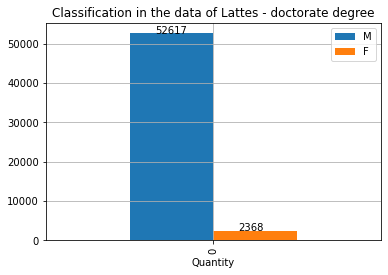

In [128]:
ax = dftmp.plot(kind="bar")
plt.title("Classification in the data of Lattes - doctorate degree")
plt.grid('True')
plt.xlabel('Quantity')
x_offset = -0.05
y_offset = 2.5
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

#### 1.5.1.6 Join data

In [118]:
data1 = load(r"./results/DoutoradoPt1.hdf5")
data2 = load(r"./results/DoutoradoPt2.hdf5")
data3 = load(r"./results/DoutoradoPt3.hdf5")
data4 = load(r"./results/DoutoradoPt4.hdf5")

In [119]:
data = np.concatenate((data1, data2, data3, data4))

In [123]:
print("M : " + str(sum(data==0)))
print("F : " + str(sum(data==1)))

M : [210681]
F : [9256]


In [124]:
dftmp = pd.DataFrame(columns=["M","F"])
dftmp["M"] = [int(sum(resu==0))]
dftmp["F"] = [int(sum(resu==1))]

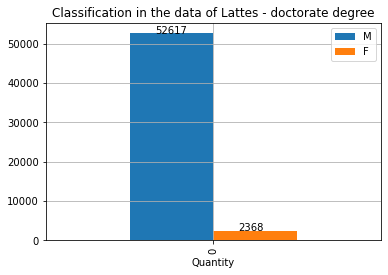

In [125]:
ax = dftmp.plot(kind="bar")
plt.title("Classification in the data of Lattes - doctorate degree")
plt.grid('True')
plt.xlabel('Quantity')
x_offset = -0.05
y_offset = 2.5
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))